In [1]:
import numpy as np
import pandas as pd 
import os
print(os.listdir("Dataset"))
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

['.ipynb_checkpoints', 'liar_plus_test.csv', 'liar_plus_train.csv', 'liar_plus_valid.csv']


In [2]:
#!pip install wordcloud

In [3]:
embeddings_index = {}
f = open("glove.6B.50d.txt",encoding="utf-8")
for line in f:
    values = line.split(' ')
    word = values[0] ## The first entry is the word
    coefs = np.asarray(values[1:], dtype='float32') ## These are the vecotrs representing the embedding for the word
    embeddings_index[word] = coefs
f.close()

print('GloVe data loaded')

GloVe data loaded


In [4]:
df=pd.read_csv("Dataset/liar_plus_train.csv")

In [5]:
df.head()

,ID,label,statement,subject,speaker,speaker_job,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context,extracted_justification
0,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,"Surovell said the decline of coal ""started whe..."
1,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver,Obama said he would have voted against the ame...
2,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,The release may have a point that Mikulskis co...
3,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN,"Crist said that the economic ""turnaround start..."
4,12465.json,true,The Chicago Bears have had more starting quart...,education,robin-vos,Wisconsin Assembly speaker,Wisconsin,republican,0.0,3.0,2.0,5.0,1.0,a an online opinion-piece,"But Vos specifically used the word ""fired,"" wh..."


In [6]:
df.dropna(subset = ["statement","context","extracted_justification"], inplace=True)

In [7]:
X_data=df["statement"]+df["context"]+df["extracted_justification"]

In [8]:
x=X_data

In [9]:
x

0        When did the decline of coal start? It started...
1        Hillary Clinton agrees with John McCain "by vo...
2        Health care reform legislation is likely to ma...
3        The economic turnaround started at the end of ...
4        The Chicago Bears have had more starting quart...
                               ...                        
10236    There are a larger number of shark attacks in ...
10237    Democrats have now become the party of the [At...
10238    Says an alternative to Social Security that op...
10239    On lifting the U.S. Cuban embargo and allowing...
10240    The Department of Veterans Affairs has a manua...
Length: 10054, dtype: object

In [10]:
import re

## Iterate over the data to preprocess by removing stopwords
lines_without_stopwords=[] 
for line in x: 
    line = line.lower()
    line_by_words = re.findall(r'(?:\w+)', line, flags = re.UNICODE) # remove punctuation ans split
    new_line=[]
    for word in line_by_words:
        if word not in stop:
            new_line.append(word)
    lines_without_stopwords.append(new_line)
texts = lines_without_stopwords

print(texts[0:5])

[['decline', 'coal', 'start', 'started', 'natural', 'gas', 'took', 'started', 'begin', 'president', 'george', 'w', 'bushs', 'administration', 'floor', 'speech', 'surovell', 'said', 'decline', 'coal', 'started', 'natural', 'gas', 'took', 'started', 'begin', 'president', 'george', 'w', 'bushs', 'administration', 'doubt', 'natural', 'gas', 'gaining', 'ground', 'coal', 'generating', 'electricity', 'trend', 'started', '1990s', 'clearly', 'gained', 'speed', 'bush', 'administration', 'production', 'natural', 'gas', 'competitor', 'coal', 'picked', 'analysts', 'give', 'little', 'credit', 'blame', 'bush', 'trend', 'note', 'factors', 'technological', 'innovation', 'entrepreneurship', 'policies', 'previous', 'administrations', 'laying', 'groundwork', 'natural', 'gas', 'boom'], ['hillary', 'clinton', 'agrees', 'john', 'mccain', 'voting', 'give', 'george', 'bush', 'benefit', 'doubt', 'iran', 'denverobama', 'said', 'would', 'voted', 'amendment', 'present', 'though', 'clinton', 'may', 'agreed', 'mccai

In [11]:
# Code adapted from (https://github.com/keras-team/keras/blob/master/examples/pretrained_word_embeddings.py)
# Vectorize the text samples

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

MAX_NUM_WORDS = 10000
MAX_SEQUENCE_LENGTH = 64
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)



Using TensorFlow backend.


Found 29866 unique tokens.


In [12]:
from sklearn.preprocessing import LabelEncoder

In [13]:
le=LabelEncoder()

In [14]:
y=le.fit_transform(df["label"])

In [15]:
y

array([2, 3, 1, ..., 2, 1, 4])

In [16]:
labels = to_categorical(np.asarray(y))
print(data.shape)
print(labels.shape)

(10054, 64)
(10054, 6)


In [17]:
## More code adapted from the keras reference (https://github.com/keras-team/keras/blob/master/examples/pretrained_word_embeddings.py)
# prepare embedding matrix 
from keras.layers import Embedding
from keras.initializers import Constant

## EMBEDDING_DIM =  ## seems to need to match the embeddings_index dimension
EMBEDDING_DIM = embeddings_index.get('a').shape[0]
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word) ## This references the loaded embeddings dictionary
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)

(10001, 50)


Text(0.5, 1.0, 'example vectors')

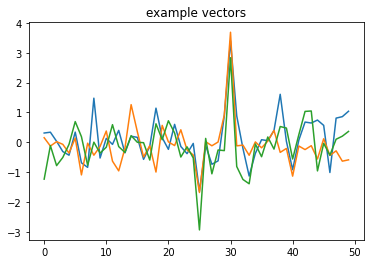

In [18]:
## Peeking at the embedding matrix values
print(embedding_matrix.shape)
plt.plot(embedding_matrix[16])
plt.plot(embedding_matrix[37])
plt.plot(embedding_matrix[18])
plt.title('example vectors')

In [19]:
def embedding_output(data):
    emb_dim=50
    max_len=64
    emb=np.zeros((10054,max_len,emb_dim))
    print(emb.shape)
    for i in range(10054):
        
        for j in range(64):
            try:
                emb[i][j]=embeddings_index[data[i][j].lower()]
            except:
                emb[i][j]=np.zeros((50,))
        return emb

In [20]:
e=embedding_output(texts)

(10054, 64, 50)


In [41]:
texts=np.array(texts)

# Stacked LSTM classifier

In [22]:
## Code from: https://medium.com/@sabber/classifying-yelp-review-comments-using-cnn-lstm-and-pre-trained-glove-word-embeddings-part-3-53fcea9a17fa
## To create and visualize a model

from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation

model = Sequential()

model.add(LSTM(64,input_shape=(64,50),return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64,input_shape=(64,50),return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(6, activation='sigmoid'))



In [39]:

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [42]:
#hist=model.fit(e,labels,epochs=50,batch_size=64,shuffle=True,validation_split=0.1)

# Attention layer Classifier

In [23]:

from keras.layers import Layer
import keras.backend as K

In [24]:
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name="att_weight",shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias",shape=(input_shape[1],1),initializer="zeros")        
        super(attention, self).build(input_shape)

    def call(self,x):
        et=K.squeeze(K.tanh(K.dot(x,self.W)+self.b),axis=-1)
        at=K.softmax(et)
        at=K.expand_dims(at,axis=-1)
        output=x*at
        return K.sum(output,axis=1)

    def compute_output_shape(self,input_shape):
        return (input_shape[0],input_shape[-1])

    def get_config(self):
        return super(attention,self).get_config()


In [25]:
from numpy import newaxis
from keras.layers import Lambda

In [26]:
def axis(a):
    a = a[ :, :, newaxis]
    return a


In [27]:
word_vector_matrix = np.zeros((10000, 50))
unavailable = 0

for word, index in tokenizer.word_index.items():
    vector = embeddings_index.get(word)
    if vector is not None:
        word_vector_matrix[index] = vector
    else:
        unavailable = unavailable + 1
        print(word)

sharethefacts
0px
politifactri
rgba
2px
adthe
wisconsins
24px
14px
2196f3
32px
werent
releasethe
theyve
20px
interviewthe
1px
cruzs
speechthe
rubios
ohios
oregons
16px
countys
kasichs
debatethe
adbut
releasebut
gingrichs
interviewbut
embed_box
64px
ffffff
5px
8px
postthe
interviewour
mcauliffes
600px
debatebut
hadnt
shouldnt
youve
10px
conferencethe
oreilly
winwidth
winheight
35em
interviewin
parentelement
crists
tweetthe
kaines
90px
grothman
releasein
260px
3px
18px
dropit
submenu
agencys
websitethe
speechbut
releaseand
25px
conferencebut
commercialthe
cuccinellis
speechour
interviewso
showthe
adtrump
santorums
adand
adwe
gillespies
debatein
adhe
cornilles
videothe
speechwe
debatetrump
speechin
omalley
congressmans
boehners
releasewe
adobama
carsons
mcdonnells
hb2
adso
mailerthe
portmans
dewhursts
arizonas
daca
emailthe
strama
providences
interviewa
interviewwe
releasea
pelosis
milwaukees
releaseour
medicares
addressthe
interviewtrump
speechand
meetingbut
0em
interviewand
stricklands


IndexError: index 10000 is out of bounds for axis 0 with size 10000

In [29]:
import keras
sequence_input = keras.layers.Input(shape=(64,), dtype='int32')
x = keras.layers.Embedding(10000, 50, input_length = 64, weights = [word_vector_matrix], trainable = False)(sequence_input)

In [30]:
att_out=attention()(x)


In [31]:
x = Lambda(axis)(att_out)

In [32]:
y = keras.layers.Conv1D(96,(11),strides = 2,activation = 'relu',input_shape=(100,1))(x)
y = keras.layers.MaxPooling1D(3,2)(y)

y = keras.layers.Conv1D(256,5,padding = 'same',activation = 'relu')(y)
y = keras.layers.MaxPooling1D(3,2)(y)

y = keras.layers.Conv1D(384,3,padding='same',activation= 'relu')(y)
y = keras.layers.Conv1D(384,3,padding='same',activation= 'relu')(y)
y = keras.layers.Conv1D(256,3,padding='same',activation= 'relu')(y)
y = keras.layers.MaxPooling1D(3,2)(y)

y = keras.layers.Flatten()(y)
y = keras.layers.Dense(128, activation = 'relu')(y)
y = keras.layers.Dense(256, activation = 'relu')(y)
y = keras.layers.Dense(64, activation = 'relu')(y)


In [33]:

output=keras.layers.Dense(6,activation='sigmoid',trainable=True)(y)

In [34]:
model=keras.Model(inputs = sequence_input,outputs = output)
model.summary()


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64)                0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 64, 50)            500000    
_________________________________________________________________
attention_1 (attention)      (None, 50)                114       
_________________________________________________________________
lambda_1 (Lambda)            (None, 50, 1)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20, 96)            1152      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 9, 96)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 9, 256)            1231

In [35]:
adam = keras.optimizers.Adadelta(learning_rate=0.0001, rho=0.95)

In [36]:
model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [40]:
epochs = 20
batch_size = 25

history = model.fit(data, labels, epochs=epochs, batch_size=batch_size,validation_split = 0.1)

Train on 9048 samples, validate on 1006 samples
Epoch 1/20
9048/9048 [==============================] - 16s 2ms/step - loss: 0.4440 - accuracy: 0.8333 - val_loss: 0.4448 - val_accuracy: 0.8333
Epoch 2/20
9048/9048 [==============================] - 15s 2ms/step - loss: 0.4442 - accuracy: 0.8333 - val_loss: 0.4448 - val_accuracy: 0.8333
Epoch 3/20
1375/9048 [===>..........................] - ETA: 12s - loss: 0.4429 - accuracy: 0.8333

KeyboardInterrupt: 